In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score,roc_auc_score
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import string
import spacy
import joblib
import pickle

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

import re

import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 300)

In [3]:
# Load the data set
reviews_df = pd.read_csv('sample30.csv')

In [4]:
reviews_df.shape

(30000, 15)

In [5]:
reviews_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


In [6]:
reviews_df.nunique()

id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64

In [7]:
#missing values
round(reviews_df.isnull().sum()/len(reviews_df)*100 ,2 ).sort_values(ascending = False)

reviews_userProvince    99.43
reviews_userCity        93.57
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_title            0.63
manufacturer             0.47
reviews_username         0.21
reviews_date             0.15
user_sentiment           0.00
reviews_text             0.00
reviews_rating           0.00
name                     0.00
categories               0.00
brand                    0.00
id                       0.00
dtype: float64

In [8]:
# dropping columns with more than 40% missing values
# also dropping 'reviews_date' as it wont be useful for sentiment prediction
reviews_df.drop(columns = ['reviews_userProvince', 'reviews_userCity', 'reviews_didPurchase' , 'reviews_date'], inplace = True)

reviews_df.shape

(30000, 11)

In [9]:
# Analyzing the target column 'user_sentiment'
reviews_df['user_sentiment'].unique()

array(['Positive', 'Negative', nan], dtype=object)

In [10]:
reviews_df['user_sentiment'].isnull().sum()

1

In [11]:

#  dropping the row with target column as nan
reviews_df = reviews_df.dropna(subset = ['user_sentiment'])
reviews_df['user_sentiment'].unique()


array(['Positive', 'Negative'], dtype=object)

In [12]:
# converting target column to numerical values
reviews_df['user_sentiment'] = reviews_df['user_sentiment'].map({'Positive':1, 'Negative': 0 })

reviews_df.head(5)

,id,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,NaN,5,Good flavor.,Good,dorothy w,1
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,rebecca,0
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0


In [13]:
reviews_df['reviews_doRecommend'].value_counts()

True     25879
False     1550
Name: reviews_doRecommend, dtype: int64

In [14]:
# imputing missing values in  'reviews_doRecommend' column witn 'N/A'
reviews_df['reviews_doRecommend'].fillna('N/A' ,inplace = True) 

reviews_df.head(5)

,id,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),N/A,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,N/A,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,N/A,5,Good flavor.,Good,dorothy w,1
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,rebecca,0
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0


In [15]:
reviews_df['reviews_title'].isna().sum()

190

In [16]:
# imputing  missing values in 'reviews_title' with space
reviews_df['reviews_title'].fillna('', inplace = True)

In [17]:
reviews_df['reviews_title'].isna().sum()

0

### EDA

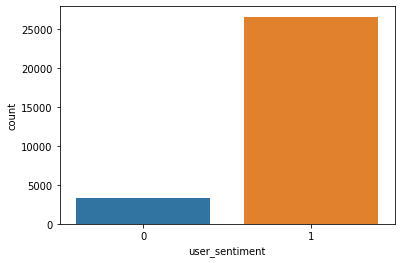

In [18]:
sns.countplot(reviews_df['user_sentiment'] );

#### The data is imbalanced, we have majority records for Positive sentiment

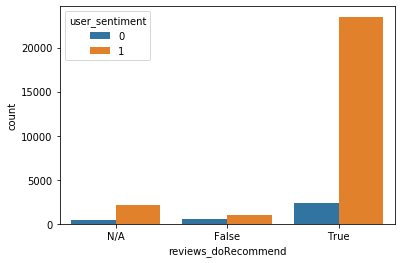

In [19]:
sns.countplot(x = reviews_df['reviews_doRecommend'], hue = reviews_df['user_sentiment']);

#### Most users who have recommended the product have given a review with Positive sentiment

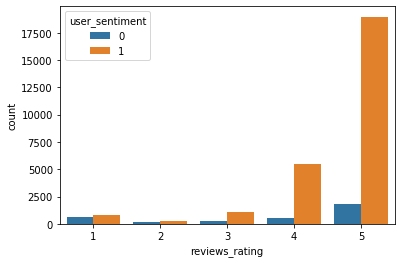

In [21]:
sns.countplot(x = reviews_df['reviews_rating'], hue = reviews_df['user_sentiment']);

#### We have mixed sentiments for Ratings 1 ,2, and 3. For ratings 4 and 5 we have higher Reviews with Positive sentiment.

### Text Pre-processing

In [23]:
# Combining the columns 'reviews_text' and 'reviews_title' into a single column 'reviews' for further analysis
reviews_df['reviews'] = reviews_df['reviews_title'] + ' ' + reviews_df['reviews_text']

In [24]:
#  converting all reviews to lowercase
reviews_df['reviews'] = reviews_df['reviews'].str.lower()

In [25]:
#  Removing punctuations
punctuation = list(string.punctuation)
reviews_df['reviews'] = reviews_df['reviews'].apply(lambda x:''.join([alpha for alpha in x if alpha not in punctuation]))

In [26]:
reviews_df['reviews'].head()

0                                                                                                  just awesome i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it 5star rating all the way her metaphors are just crazy
1                                                                                                                                                                                                                                              good good flavor this review was collected as part of a promotion
2                                                                                                                                                                                                                                                                                               good good flavor
3    disappointed i read through the reviews on here before looking in to buying one 

In [27]:
stop_words = stopwords.words('english')

In [28]:
# Removing Stopwords
reviews_df['reviews'] = reviews_df['reviews'].apply(lambda x:(' '.join([str(word) for word in word_tokenize(x) if word not in stop_words])))

In [29]:
reviews_df['reviews'].head()

0                                                                                                                                                                                          awesome love album good hip hop side current pop sound hype listen everyday gym give 5star rating way metaphors crazy
1                                                                                                                                                                                                                                                               good good flavor review collected part promotion
2                                                                                                                                                                                                                                                                                               good good flavor
3    disappointed read reviews looking buying one couples lubricants ultimately disap

In [30]:
# creating a vocab of all the words for applying spell correction later
word_list=[]
for i in reviews_df['reviews']:
    for j in i.split():
        word_list.append(j)

In [31]:
len(word_list)

597089

In [32]:
from spellchecker import SpellChecker
spell = SpellChecker()

In [33]:
#  Creating a list of all unknown words
unknown_words=spell.unknown(word_list)

In [34]:
list(unknown_words)[0:10]

['sparktype',
 '2u',
 'evoo',
 'customrsbring',
 'terriblepleasebring',
 'seehear',
 'tbs',
 'investmet',
 'dvdnot',
 'puhleeeezze']

In [35]:
len(unknown_words)

7409

In [36]:
# Applying spellchecker 
reviews_df['reviews']=reviews_df['reviews'].apply(lambda x: " ".join([ spell.correction(word) if word in unknown_words else word for word in x.split() ]))

In [37]:
# Lemmatize using SPACY 
nlp = spacy.load("en_core_web_sm")
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'ADP']
reviews_df['reviews'] = reviews_df['reviews'].apply(lambda x:' '.join([token.lemma_ for token in nlp(str(x)) if token.pos_ in allowed_postags]))


In [38]:
# checking the results on random data 
reviews_df['reviews'][17950:17955]

17950                                                                                                                                                                                                                                                           kissable soft product leave lip kissable soft sticky
17951                                                                                                                                                              fantastic try numerous type chopstick lip always chap winter try instantly feel difference feel great smell nice keep lip smooth glossy hour time
17952                                                                                                                                                         really love stuff total lip balm fanatic replace many lip balm purse dry crack lip instantly smooth stay way long time love much go try rise tint next
17953    amazingly protective chronic angular cheilitis basically mean li

In [39]:
# removing all the numeric content in the text.
reviews_df['reviews'] = reviews_df['reviews'].apply(lambda x: ' '.join([str(word) for word in x.split() if re.match('.*[0-9]+' , word) == None]))

In [40]:
reviews_df.head()

,id,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),N/A,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,N/A,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1,good good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,N/A,5,Good flavor.,Good,dorothy w,1,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,rebecca,0,disappointed read review look buy couple lubricant ultimately disappoint even live review read starter boyfriend notice sort enhance captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially lack captivating sensation expect disappoin...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0,irritation husband buy gel gel cause irritation feel like burn skin recommend gel


### Using wordcloud to get a visual of the most common words for all 5 ratings

In [345]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

In [346]:
# creating a function to generate wordcloud
def wcloud(words, rating):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)
  
    # plot the WordCloud image                       
    plt.figure(figsize = (8, 8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    title = ' Wordcloud for words in reviews with rating '+ str(rating)
    plt.title(title) 

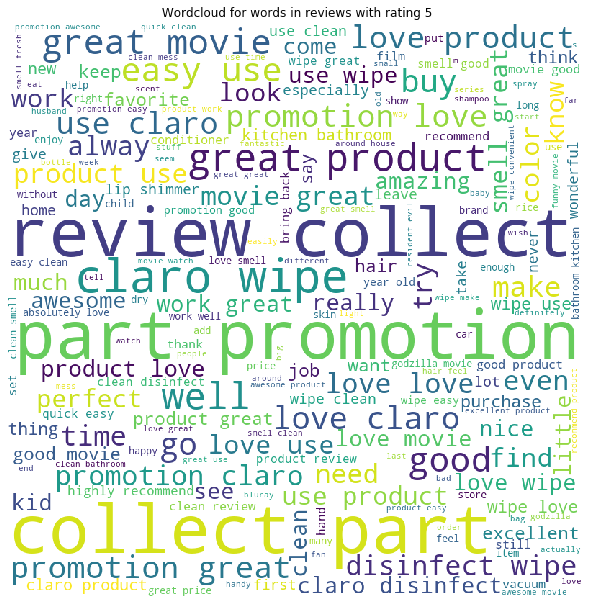

In [347]:
#  all reviews with rating 5 
words_rating_5 = ' '.join(review for review in reviews_df['reviews'][reviews_df.reviews_rating == 5])
wcloud(words_rating_5,5)

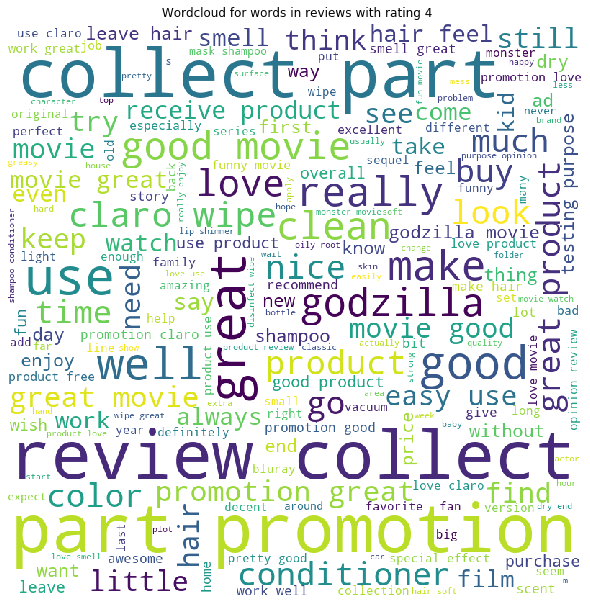

In [348]:
#  all reviews with rating 4
words_rating_4 = ' '.join(review for review in reviews_df['reviews'][reviews_df.reviews_rating == 4])
wcloud(words_rating_4,4)

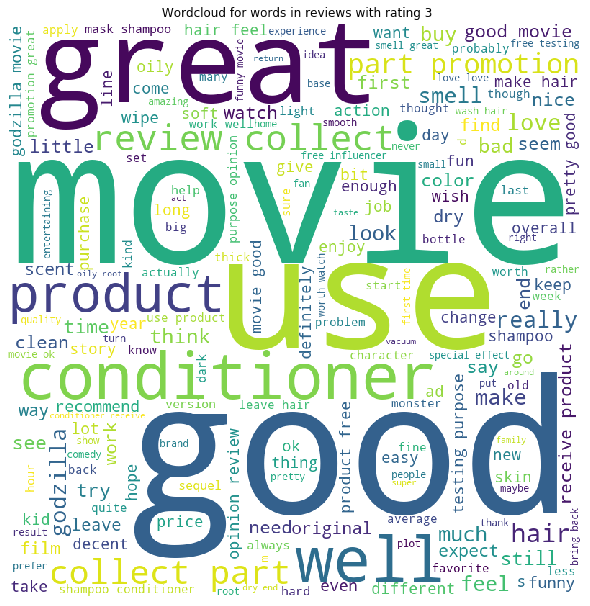

In [349]:
#  all reviews with rating 3
words_rating_3 = ' '.join(review for review in reviews_df['reviews'][reviews_df.reviews_rating == 3])
wcloud(words_rating_3,3)

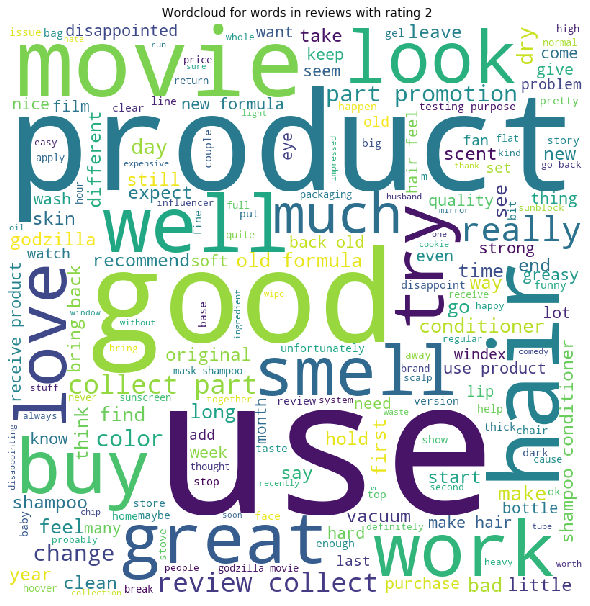

In [350]:
#  all reviews with rating 2
words_rating_2 = ' '.join(review for review in reviews_df['reviews'][reviews_df.reviews_rating == 2])
wcloud(words_rating_2,2)

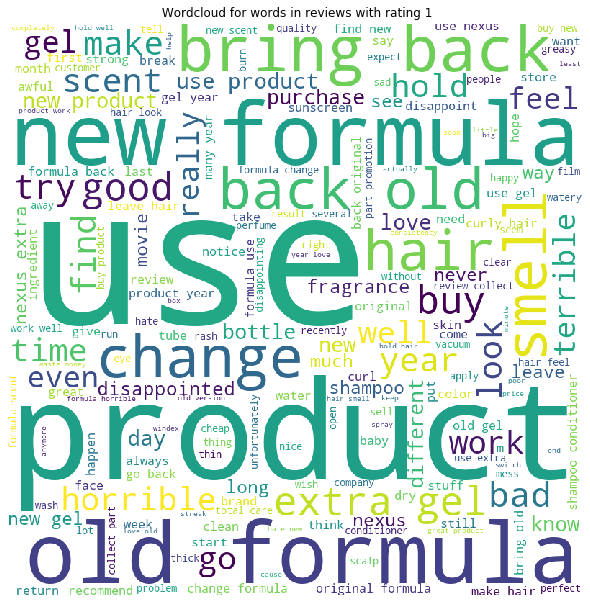

In [351]:
#  all reviews with rating 1
words_rating_1 = ' '.join(review for review in reviews_df['reviews'][reviews_df.reviews_rating == 1])
wcloud(words_rating_1,1)

#### Creating Train and Test datasets

In [41]:
X = reviews_df['reviews']
y = reviews_df['user_sentiment']

In [42]:
# splitting the data into Train and test datasets
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size = 0.7, random_state = 100 )

In [43]:
print(X_train.shape)
print(X_test.shape)

(20999,)
(9000,)


### Using TF-IDF for Feature Extraction

In [44]:
tfidf_vec=TfidfVectorizer(stop_words='english', max_features= 5000 ) 

In [45]:
X_tfidf_train = tfidf_vec.fit_transform(X_train)

len(tfidf_vec.vocabulary_)

5000

In [46]:
X_tfidf_test = tfidf_vec.transform(X_test)

In [47]:
y_train.value_counts()

1    18647
0     2352
Name: user_sentiment, dtype: int64

#### Balancing the data using SMOTE

In [48]:
# Using SMOTE to balance the train data 
oversample = SMOTE()
X_tfidf_train, y_tfidf_train = oversample.fit_resample(X_tfidf_train, y_train)

y_tfidf_train.value_counts()

1    18647
0    18647
Name: user_sentiment, dtype: int64

### MODEL Building


### 1. Using Logistic Regression on TFIDF

In [49]:
logreg = LogisticRegression(random_state= 42)

logreg.fit(X_tfidf_train, y_tfidf_train)

y_tfidf_train_pred = logreg.predict(X_tfidf_train)
y_tfidf_test_pred = logreg.predict(X_tfidf_test)

In [50]:
#Logistic Model accuracy
print('Logistic Model accuracy using TF-IDF: {:.4f}'.format(accuracy_score(y_test,y_tfidf_test_pred)))

# caluclate confusion matrix
cm_lr = confusion_matrix(y_test, y_tfidf_test_pred)
print(cm_lr)

specificity = cm_lr[0,0]/(cm_lr[0,0]+cm_lr[0,1])
sensitivity = cm_lr[1,1]/(cm_lr[1,0]+cm_lr[1,1])
print('specificity:', specificity)
print('sensitivity:' , sensitivity)

Logistic Model accuracy using TF-IDF: 0.8656
[[ 717  298]
 [ 912 7073]]
specificity: 0.7064039408866996
sensitivity: 0.8857858484658735


####  Hyperparameters Tuning on Logistic model

In [51]:
#HYPERPARAM TUNING on LR
c_values = [5, 1.0, 0.5, 0.1]

parameters =  dict(C=c_values)

n_folds = 5

lr = GridSearchCV(logreg, parameters, 
                    cv=n_folds, return_train_score=True,
                   scoring="roc_auc")
lr.fit(X_tfidf_train, y_tfidf_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [5, 1.0, 0.5, 0.1]}, return_train_score=True,
             scoring='roc_auc')

In [52]:
# summarize results
print("Best: %f using %s" % (lr.best_score_, lr.best_params_))
means = lr.cv_results_['mean_test_score']
stds = lr.cv_results_['std_test_score']
params = lr.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.973337 using {'C': 5}
0.973337 (0.008785) with: {'C': 5}
0.965960 (0.011292) with: {'C': 1.0}
0.960529 (0.012954) with: {'C': 0.5}
0.940315 (0.017456) with: {'C': 0.1}


In [53]:
pred_train_y = lr.predict(X_tfidf_train)
pred_test_y = lr.predict(X_tfidf_test)
print("Train accuracy: ", accuracy_score(y_tfidf_train,pred_train_y ))
print("Test accuracy: ", accuracy_score(y_test,pred_test_y))

Train accuracy:  0.947739582774709
Test accuracy:  0.8772222222222222


In [56]:
# caluclate confusion matrix
cm_tfidf = confusion_matrix(y_test, pred_test_y)
print(cm_tfidf)

specificity = cm_tfidf[0,0]/(cm_tfidf[0,0]+cm_tfidf[0,1])
sensitivity = cm_tfidf[1,1]/(cm_tfidf[1,0]+cm_tfidf[1,1])
print('specificity:', specificity)
print('sensitivity:' , sensitivity)

[[ 683  332]
 [ 773 7212]]
specificity: 0.6729064039408867
sensitivity: 0.9031934877896055


In [57]:
TP = cm_tfidf[1,1] # true positive 
TN = cm_tfidf[0,0] # true negatives
FP = cm_tfidf[0,1] # false positives
FN = cm_tfidf[1,0] # false negatives

Accuracy_LR = round(accuracy_score(y_test,pred_test_y) ,2)
Senstivity_LR = round((TP / float(TP+FN)),2)
Specificity_LR = round((TN / float(TN+FP)),2)
FPR_LR = round((FP/ float(TN+FP)),2)
Pos_pred_val_LR = round((TP / float(TP+FP)),2)
Neg_pred_val_LR = round((TN / float(TN+ FN)),2)

print('Acuracy Score:',Accuracy_LR )

# sensitivity

print('Sensitivity:', Senstivity_LR)

# specificity
print('Specificity:', Specificity_LR)

# false postive rate
print('false postive rate:', FPR_LR)

# positive predictive value 
print('positive predictive value:', Pos_pred_val_LR)

# Negative predictive value
print('Negative predictive value:', Neg_pred_val_LR)

Acuracy Score: 0.88
Sensitivity: 0.9
Specificity: 0.67
false postive rate: 0.33
positive predictive value: 0.96
Negative predictive value: 0.47


### 2. MNB 

In [58]:
mnb = MultinomialNB()

#fit on training data
mnb.fit(X_tfidf_train, y_tfidf_train)

# predict class
pred_train_y = mnb.predict(X_tfidf_train)
pred_test_y = mnb.predict(X_tfidf_test)

# accuracy
print("Train accuracy: ", accuracy_score(y_tfidf_train, pred_train_y))
print("Test accuracy: ", accuracy_score(y_test, pred_test_y))

Train accuracy:  0.8220893441304231
Test accuracy:  0.818


In [59]:
# caluclate confusion matrix
cm_mnb = confusion_matrix(y_test, pred_test_y)
print(cm_mnb)

specificity = cm_mnb[0,0]/(cm_mnb[0,0]+cm_mnb[0,1])
sensitivity = cm_mnb[1,1]/(cm_mnb[1,0]+cm_mnb[1,1])
print('specificity:', specificity)
print('sensitivity:' , sensitivity)

[[ 603  412]
 [1226 6759]]
specificity: 0.594088669950739
sensitivity: 0.8464621164683782


In [60]:
TP = cm_mnb[1,1] # true positive 
TN = cm_mnb[0,0] # true negatives
FP = cm_mnb[0,1] # false positives
FN = cm_mnb[1,0] # false negatives

Accuracy_MNB = round(accuracy_score(y_test,pred_test_y) ,2)
Senstivity_MNB = round((TP / float(TP+FN)),2)
Specificity_MNB = round((TN / float(TN+FP)),2)
FPR_MNB = round((FP/ float(TN+FP)),2)
Pos_pred_val_MNB = round((TP / float(TP+FP)),2)
Neg_pred_val_MNB = round((TN / float(TN+ FN)),2)

print('Acuracy Score:',Accuracy_MNB )

# sensitivity
print('Sensitivity:', Senstivity_MNB)

# specificity
print('Specificity:', Specificity_MNB)

# false postive rate
print('false postive rate:', FPR_MNB)

# positive predictive value 
print('positive predictive value:', Pos_pred_val_MNB)

# Negative predictive value
print('Negative predictive value:', Neg_pred_val_MNB)

Acuracy Score: 0.82
Sensitivity: 0.85
Specificity: 0.59
false postive rate: 0.41
positive predictive value: 0.94
Negative predictive value: 0.33


### 3.Random Forest 

In [61]:
#  Running the random forest with default parameters.
rfc = RandomForestClassifier(random_state=100)

In [62]:
# fit
rfc.fit(X_tfidf_train,y_tfidf_train)

# Making predictions
y_train_pred_rf = rfc.predict(X_tfidf_train)
y_test_pred_rf = rfc.predict(X_tfidf_test)

# Checking the report of default model
print('Test classification:\n',classification_report(y_test,y_test_pred_rf))

# Printing confusion matrix
print(confusion_matrix(y_test,y_test_pred_rf))

Test classification:
               precision    recall  f1-score   support

           0       0.60      0.45      0.52      1015
           1       0.93      0.96      0.95      7985

    accuracy                           0.90      9000
   macro avg       0.77      0.71      0.73      9000
weighted avg       0.90      0.90      0.90      9000

[[ 458  557]
 [ 301 7684]]


####  Hyperparameter Tuning on Random Forest

 ###### a) Tuning Max_Depth

In [87]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(50, 100, 5)}


# fit randomforest on training data
rf = GridSearchCV(rfc, parameters, 
                    cv=n_folds, return_train_score=True,
                   scoring="accuracy")
rf.fit(X_tfidf_train, y_tfidf_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             param_grid={'max_depth': range(50, 100, 5)},
             return_train_score=True, scoring='accuracy')

In [88]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,9.638942,0.579562,0.165975,0.008668,50,{'max_depth': 50},0.902266,0.944765,0.945703,0.940609,...,0.934815,0.016405,10,0.975230,0.975432,0.975901,0.975800,0.975768,0.975626,0.000253
1,10.855952,0.471554,0.166148,0.004755,55,{'max_depth': 55},0.907897,0.951602,0.953211,0.947714,...,0.941653,0.017012,9,0.980727,0.980426,0.981264,0.981096,0.980493,0.980801,0.000329
2,11.476106,0.335093,0.181107,0.007742,60,{'max_depth': 60},0.916343,0.953211,0.955222,0.950395,...,0.945729,0.014774,8,0.984649,0.984247,0.984046,0.984649,0.985018,0.984522,0.000341
3,15.848454,2.790762,0.236805,0.035778,65,{'max_depth': 65},0.920365,0.954954,0.955758,0.954283,...,0.948035,0.013843,7,0.987531,0.986425,0.986727,0.987163,0.987666,0.987102,0.000470
4,16.939292,2.825034,0.218216,0.035319,70,{'max_depth': 70},0.926934,0.957501,0.960182,0.953613,...,0.951226,0.012328,6,0.989677,0.988436,0.988939,0.989040,0.989174,0.989053,0.000399


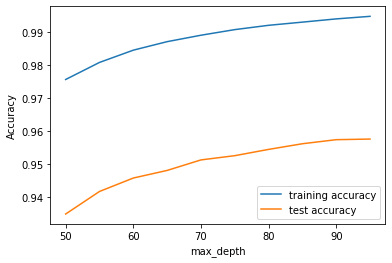

In [89]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### b) Tuning n-estimators

In [69]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(10, 100, 10)}
rfc = RandomForestClassifier(random_state=100)

# fit randomforest on training data
rf = GridSearchCV(rfc, parameters, 
                    cv=n_folds, return_train_score=True,
                   scoring="accuracy")
rf.fit(X_tfidf_train, y_tfidf_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             param_grid={'n_estimators': range(10, 100, 10)},
             return_train_score=True, scoring='accuracy')

In [70]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.206775,0.098912,0.031091,0.003460,10,{'n_estimators': 10},0.920365,0.944765,0.943826,0.943558,...,0.938677,0.009247,9,0.997587,0.997453,0.997654,0.997319,0.997989,0.997600,0.000226
1,4.373920,0.108547,0.059650,0.006969,20,{'n_estimators': 20},0.931894,0.957769,0.959512,0.956697,...,0.952513,0.010360,8,0.999598,0.999631,0.999531,0.999497,0.999464,0.999544,0.000062
2,6.801680,0.302278,0.090099,0.003072,30,{'n_estimators': 30},0.932297,0.962327,0.962730,0.960182,...,0.956267,0.012043,7,0.999866,0.999799,0.999698,0.999765,0.999765,0.999779,0.000054
3,8.951482,0.406360,0.120132,0.009655,40,{'n_estimators': 40},0.936319,0.963802,0.967154,0.962730,...,0.959404,0.011673,6,0.999899,0.999832,0.999698,0.999765,0.999765,0.999792,0.000068
4,11.381106,0.179978,0.155525,0.010213,50,{'n_estimators': 50},0.938061,0.967020,0.969299,0.964204,...,0.961013,0.011589,5,0.999933,0.999765,0.999765,0.999799,0.999799,0.999812,0.000062


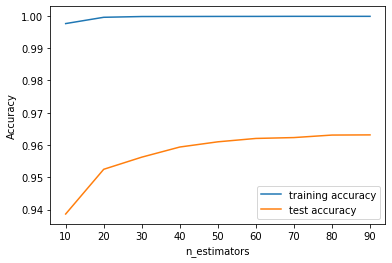

In [71]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### c)Tuning max_features

In [72]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': range(1, 30, 5)}
rfc = RandomForestClassifier(random_state=100)


# fit randomforest on training data
rf = GridSearchCV(rfc, parameters, 
                    cv=n_folds, return_train_score=True,
                   scoring="accuracy")
rf.fit(X_tfidf_train, y_tfidf_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             param_grid={'max_features': range(1, 30, 5)},
             return_train_score=True, scoring='accuracy')

In [73]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,21.711797,1.461423,1.208461,0.075470,1,{'max_features': 1},0.954686,0.981365,0.984448,0.980024,...,0.975921,0.010771,1,0.999933,0.999832,0.999799,0.999832,0.999799,0.999839,0.000049
1,20.752955,1.226388,0.689573,0.099750,6,{'max_features': 6},0.947580,0.977477,0.976807,0.974259,...,0.970317,0.011422,2,0.999933,0.999832,0.999799,0.999832,0.999799,0.999839,0.000049
2,20.821251,1.621663,0.541196,0.039860,11,{'max_features': 11},0.946508,0.975332,0.977209,0.971310,...,0.968815,0.011321,3,0.999933,0.999832,0.999799,0.999832,0.999799,0.999839,0.000049
3,20.561168,0.915906,0.460643,0.032610,16,{'max_features': 16},0.943826,0.973723,0.976270,0.971042,...,0.967743,0.012072,4,0.999933,0.999832,0.999799,0.999832,0.999799,0.999839,0.000049
4,19.788433,1.337072,0.406621,0.028597,21,{'max_features': 21},0.941949,0.973723,0.976002,0.970103,...,0.966241,0.012381,5,0.999933,0.999832,0.999799,0.999832,0.999799,0.999839,0.000049


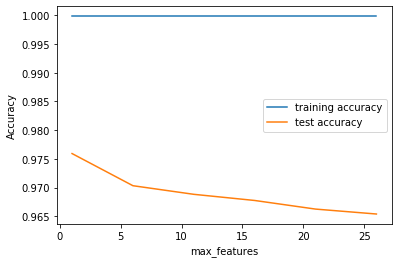

In [74]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### d) Tuning min_samples_leaf

In [90]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(30, 200, 30)}
rfc = RandomForestClassifier(random_state=100)

# fit randomforest on training data
rf = GridSearchCV(rfc, parameters, 
                    cv=n_folds, return_train_score=True,
                   scoring="accuracy")
rf.fit(X_tfidf_train, y_tfidf_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             param_grid={'min_samples_leaf': range(30, 200, 30)},
             return_train_score=True, scoring='accuracy')

In [91]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.492696,0.112112,0.110894,0.003550,30,{'min_samples_leaf': 30},0.728516,0.829736,0.830808,0.826652,...,0.808415,0.039986,1,0.835127,0.816256,0.815787,0.815552,0.818877,0.820320,0.007498
1,1.870753,0.141882,0.092733,0.002533,60,{'min_samples_leaf': 60},0.721679,0.816866,0.814050,0.812441,...,0.795759,0.037068,2,0.816658,0.801810,0.800637,0.799799,0.805269,0.804835,0.006199
2,1.422441,0.107118,0.081177,0.003123,90,{'min_samples_leaf': 90},0.719131,0.808419,0.810162,0.804129,...,0.789538,0.035264,3,0.807743,0.793732,0.794268,0.791889,0.795951,0.796717,0.005663
3,1.175649,0.080429,0.074402,0.001962,120,{'min_samples_leaf': 120},0.720874,0.800107,0.803995,0.795147,...,0.783236,0.031340,4,0.804022,0.783979,0.787498,0.783945,0.786500,0.789189,0.007547
4,0.999910,0.069626,0.071007,0.000980,150,{'min_samples_leaf': 150},0.716584,0.795683,0.793404,0.793270,...,0.777525,0.030555,5,0.795442,0.778817,0.779688,0.782035,0.782746,0.783745,0.006025


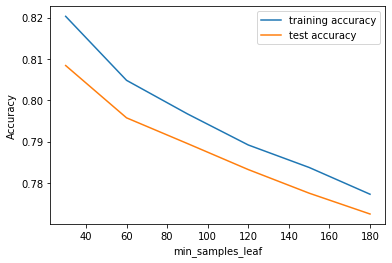

In [92]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


#### e) Tuning min_samples_split

In [93]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(50, 300, 50)}
rfc = RandomForestClassifier(random_state=100)

# fit randomforest on training data
rf = GridSearchCV(rfc, parameters, 
                    cv=n_folds, return_train_score=True,
                   scoring="accuracy")
rf.fit(X_tfidf_train, y_tfidf_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             param_grid={'min_samples_split': range(50, 300, 50)},
             return_train_score=True, scoring='accuracy')

In [94]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,10.474995,0.311379,0.343684,0.183222,50,{'min_samples_split': 50},0.888055,0.955758,0.956428,0.952541,...,0.941492,0.026751,1,0.989442,0.990548,0.990280,0.991218,0.990548,0.990407,0.000574
1,8.892331,0.620122,0.241964,0.015713,100,{'min_samples_split': 100},0.860705,0.941547,0.944094,0.940341,...,0.925913,0.032628,2,0.976370,0.977376,0.977007,0.978783,0.977343,0.977376,0.000791
2,8.034134,0.328164,0.251488,0.047337,150,{'min_samples_split': 150},0.841668,0.934039,0.932833,0.932699,...,0.914357,0.036362,3,0.964304,0.965209,0.963164,0.966851,0.965143,0.964934,0.001210
3,7.207202,0.284278,0.221698,0.010762,200,{'min_samples_split': 200},0.824373,0.926130,0.926800,0.921973,...,0.904596,0.040149,4,0.953779,0.954952,0.952673,0.955790,0.954853,0.954410,0.001078
4,6.777389,0.319623,0.228498,0.008404,250,{'min_samples_split': 250},0.813246,0.920499,0.918220,0.915940,...,0.896311,0.041595,5,0.944461,0.945266,0.943255,0.945802,0.943391,0.944435,0.001004


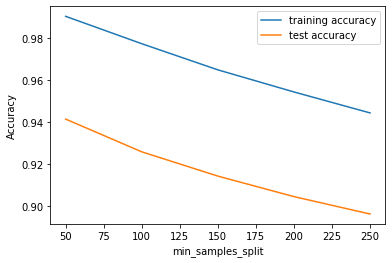

In [95]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Grid Search to Find Optimal Hyperparameters

In [96]:
n_folds = 5

# parameters to build the model on
parameters = {
    'max_depth': [80,90],
    'n_estimators': [50,60], 
    'max_features': [5, 10],
    'min_samples_leaf': [50,100],
    'min_samples_split': [50,75]
    
}

rfc = RandomForestClassifier(random_state=100)
# fit tree on training data
rf = GridSearchCV(rfc, parameters, 
                    return_train_score=True,  
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_tfidf_train, y_tfidf_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             param_grid={'max_depth': [80, 90], 'max_features': [5, 10],
                         'min_samples_leaf': [50, 100],
                         'min_samples_split': [50, 75],
                         'n_estimators': [50, 60]},
             return_train_score=True, scoring='accuracy')

In [97]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',rf.best_score_,'using',rf.best_params_)

We can get accuracy of 0.7265779377608409 using {'max_depth': 80, 'max_features': 10, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 60}


#### Fitting the final model with the best parameters obtained from grid search.

In [98]:
# model with the best hyperparameters
rfc = RandomForestClassifier(
                             bootstrap=True,
                             max_depth=80,
                             max_features=10,
                             min_samples_leaf=50, 
                             min_samples_split=50,
                             n_estimators=60,
                             random_state=100)

# fit
rfc.fit(X_tfidf_train,y_tfidf_train)

RandomForestClassifier(max_depth=80, max_features=10, min_samples_leaf=50,
                       min_samples_split=50, n_estimators=60, random_state=100)

In [99]:
# predict
y_test_pred_rf_hyper = rfc.predict(X_tfidf_test)

In [100]:
print(classification_report(y_test,y_test_pred_rf_hyper))

              precision    recall  f1-score   support

           0       0.20      0.61      0.30      1015
           1       0.93      0.68      0.79      7985

    accuracy                           0.67      9000
   macro avg       0.56      0.65      0.54      9000
weighted avg       0.85      0.67      0.73      9000



In [101]:
cm_rf = confusion_matrix(y_test,y_test_pred_rf_hyper)
print(' Confusion matrix: ' , cm_rf)

 Confusion matrix:  [[ 619  396]
 [2535 5450]]


In [102]:
TP = cm_rf[1,1] # true positive 
TN = cm_rf[0,0] # true negatives
FP = cm_rf[0,1] # false positives
FN = cm_rf[1,0] # false negatives

Accuracy_RF = round(accuracy_score(y_test,y_test_pred_rf_hyper) ,2)
Senstivity_RF = round((TP / float(TP+FN)),2)
Specificity_RF = round((TN / float(TN+FP)),2)
FPR_RF = round((FP/ float(TN+FP)),2)
Pos_pred_val_RF = round((TP / float(TP+FP)),2)
Neg_pred_val_RF = round((TN / float(TN+ FN)),2)

print('Acuracy Score:',Accuracy_RF )

# sensitivity
print('Sensitivity:', Senstivity_RF)

# specificity
print('Specificity:', Specificity_RF)

# false postive rate
print('false postive rate:', FPR_RF)

# positive predictive value 
print('positive predictive value:', Pos_pred_val_RF)

# Negative predictive value
print('Negative predictive value:', Neg_pred_val_RF)

Acuracy Score: 0.67
Sensitivity: 0.68
Specificity: 0.61
false postive rate: 0.39
positive predictive value: 0.93
Negative predictive value: 0.2


### 4. XGBoost

In [104]:
# fit model on training data with default hyperparameters
Xgboost = XGBClassifier(eval_metric = 'auc', random_state = 100) 
Xgboost.fit(X_tfidf_train,y_tfidf_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=100, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [105]:
# make predictions for test data
y_pred_xgboost = Xgboost.predict(X_tfidf_test)
y_pred_xgboost[:10]

array([1, 1, 0, 1, 1, 0, 1, 1, 1, 0], dtype=int64)

In [106]:
# evaluate predictions
roc = roc_auc_score(y_test, y_pred_xgboost)
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 76.30%


In [107]:
# evaluate predictions
roc = accuracy_score(y_test, y_pred_xgboost)
print("Accuracy: %.2f%%" % (roc * 100.0))

Accuracy: 87.02%


### hyperparameter tuning with XGBoost

In [108]:
# creating a KFold object 
folds = 5

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9], 
             }          


# specify model
xgb_model = XGBClassifier(eval_metric = 'auc')

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)  

In [109]:
model_cv.fit(X_tfidf_train,y_tfidf_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.5min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='auc',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None

In [110]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.560111,0.103823,0.069812,0.003888,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.926654,0.966559,0.964909,...,0.957472,0.015427,6,0.976073,0.969166,0.969783,0.969914,0.969030,0.970793,0.002662
1,4.915343,0.340159,0.072007,0.005140,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.932019,0.970513,0.970086,...,0.961638,0.014854,4,0.980913,0.975480,0.976685,0.975846,0.975846,0.976954,0.002019
2,6.057134,0.073981,0.068616,0.003302,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.935353,0.971300,0.970447,...,0.963221,0.013950,3,0.982751,0.978386,0.977929,0.978221,0.977977,0.979053,0.001857
3,3.392091,0.139563,0.082179,0.006389,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.930306,0.968738,0.969854,...,0.961368,0.015561,5,0.986729,0.981522,0.982561,0.981573,0.981091,0.982695,0.002074
4,4.892375,0.080509,0.076792,0.003454,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.944005,0.979484,0.978193,...,0.971405,0.013721,2,0.992964,0.989887,0.989565,0.990283,0.989570,0.990454,0.001282
5,6.159658,0.076488,0.083177,0.002931,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.951662,0.982801,0.980361,...,0.975205,0.011805,1,0.995100,0.992497,0.992693,0.992994,0.992481,0.993153,0.000991


In [111]:
print(model_cv.best_score_ , model_cv.best_params_)

0.9752046665796689 {'learning_rate': 0.6, 'subsample': 0.9}


In [112]:
# creating a KFold object 
folds = 5

# specify range of hyperparameters
param_grid = {'learning_rate': [0.6], 
             'subsample': [0.9], 
              'max_depth' : [10,15]
             }          


# specify model
xgb_model = XGBClassifier(eval_metric = 'auc')

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)  

In [113]:
model_cv.fit(X_tfidf_train,y_tfidf_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.7min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='auc',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None

In [114]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
print(model_cv.best_score_ , model_cv.best_params_)

0.98530636885867 {'learning_rate': 0.6, 'max_depth': 15, 'subsample': 0.9}


In [115]:
# creating a KFold object 
folds = 5

# specify range of hyperparameters
param_grid = {'learning_rate': [0.6], 
             'subsample': [0.9], 
              'max_depth' : [15],
              'n_estimators':[50,60]
             }          


# specify model
xgb_model = XGBClassifier(eval_metric = 'auc')

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)  

In [116]:
model_cv.fit(X_tfidf_train,y_tfidf_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.2min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='auc',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None

In [117]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
print(model_cv.best_score_ , model_cv.best_params_)

0.9829857345020402 {'learning_rate': 0.6, 'max_depth': 15, 'n_estimators': 60, 'subsample': 0.9}


In [120]:
# fit model on training data using the chosen hyperparameters
model = XGBClassifier(learning_rate = 0.6,max_depth = 15, n_estimators = 60 , subsample = 0.9, eval_metric = 'auc')
model.fit(X_tfidf_train, y_tfidf_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.6, max_delta_step=0,
              max_depth=15, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=60, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [121]:
# predict
y_pred_xgboost = model.predict(X_tfidf_test)
y_pred_xgboost[:10]

array([1, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int64)

In [122]:
# roc_auc
auc = roc_auc_score(y_test, y_pred_xgboost)
auc

0.7505816015867189

In [123]:
cm_xgb = confusion_matrix(y_test,y_pred_xgboost)
print(' Confusion matrix: ' , cm_xgb)

 Confusion matrix:  [[ 573  442]
 [ 506 7479]]


In [124]:

TP = cm_xgb[1,1] # true positive 
TN = cm_xgb[0,0] # true negatives
FP = cm_xgb[0,1] # false positives
FN = cm_xgb[1,0] # false negatives

Accuracy_XGB = round(accuracy_score(y_test,y_pred_xgboost) ,2)
Senstivity_XGB = round((TP / float(TP+FN)),2)
Specificity_XGB = round((TN / float(TN+FP)),2)
FPR_XGB = round((FP/ float(TN+FP)),2)
Pos_pred_val_XGB = round((TP / float(TP+FP)),2)
Neg_pred_val_XGB = round((TN / float(TN+ FN)),2)

print('Acuracy Score:',Accuracy_XGB )

# sensitivity
print('Sensitivity:', Senstivity_XGB)

# specificity
print('Specificity:', Specificity_XGB)

# false postive rate
print('false postive rate:', FPR_XGB)

# positive predictive value 
print('positive predictive value:', Pos_pred_val_XGB)

# Negative predictive value
print('Negative predictive value:', Neg_pred_val_XGB)

Acuracy Score: 0.89
Sensitivity: 0.94
Specificity: 0.56
false postive rate: 0.44
positive predictive value: 0.94
Negative predictive value: 0.53


### MODEL COMPARISON

In [144]:
print('|                | Logistic | Multinomial Naive Bayes | Random Forest | XGBoost |')
print('| -------------  | -------- | ----------------------- | ------------- | --------| ')
print('| Accuracy       |',Accuracy_LR ,'    |', Accuracy_MNB , '                   |', Accuracy_RF,'         |', Accuracy_XGB,'   | ')
print('| Sensitivity    |',Senstivity_LR ,'     |', Senstivity_MNB , '                   |', Senstivity_RF,'         |', Senstivity_XGB,'   | ')
print('| Specificity    |',Specificity_LR ,'    |', Specificity_MNB , '                   |', Specificity_RF,'         |', Specificity_XGB,'   | ')
print('| False Pos rate |',FPR_LR ,'    |', FPR_MNB , '                   |', FPR_RF,'         |', FPR_XGB,'   | ')

print('| Pos Pred Value |',Pos_pred_val_LR ,'    |', Pos_pred_val_MNB , '                   |', Pos_pred_val_RF,'         |', Pos_pred_val_XGB,'   | ')
print('| Neg Pred Value |',Neg_pred_val_LR ,'    |', Neg_pred_val_MNB , '                   |', Neg_pred_val_RF,'          |', Neg_pred_val_XGB,'   | ')

|                | Logistic | Multinomial Naive Bayes | Random Forest | XGBoost |
| -------------  | -------- | ----------------------- | ------------- | --------| 
| Accuracy       | 0.88     | 0.82                    | 0.67          | 0.89    | 
| Sensitivity    | 0.9      | 0.85                    | 0.68          | 0.94    | 
| Specificity    | 0.67     | 0.59                    | 0.61          | 0.56    | 
| False Pos rate | 0.33     | 0.41                    | 0.39          | 0.44    | 
| Pos Pred Value | 0.96     | 0.94                    | 0.93          | 0.94    | 
| Neg Pred Value | 0.47     | 0.33                    | 0.2           | 0.53    | 


### LOGISTIC Model seems to be the best option here based on the metrics above

### saving Logistic Regression model to a pickle file

In [152]:
joblib.dump(lr, 'model/sentiment_model.pkl')

['model/sentiment_model.pkl']

### Saving the dataframe with TF-IDF values in a Pickle for later use

In [153]:
# creating a Dataframe with the Product Id , name  and  pre-processed reviews text
prediction_df = pd.concat([reviews_df[['id', 'name']].reset_index(drop = True), X.reset_index(drop = True)], axis =1 )

In [154]:
prediction_df.head()

,id,name,reviews
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,good good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,disappointed read review look buy couple lubricant ultimately disappoint even live review read starter boyfriend notice sort enhance captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially lack captivating sensation expect disappoin...
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,irritation husband buy gel gel cause irritation feel like burn skin recommend gel


In [155]:
prediction_df.shape

(29999, 3)

In [156]:
# creating  a data frame with tf-idf values for all the reviews 
reviews_tfidf = tfidf_vec.transform(prediction_df['reviews'])

In [157]:
reviews_tfidf.shape

(29999, 5000)

In [158]:
# adding the tf-idf values to the prediction_df
prediction_df = pd.concat([prediction_df.reset_index(drop = True), pd.DataFrame(reviews_tfidf.toarray()).reset_index(drop = True)], axis =1 )

In [159]:
prediction_df.head()

,id,name,reviews,0,1,2,3,4,5,6,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,good good flavor review collect part promotion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,good good flavor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,disappointed read review look buy couple lubricant ultimately disappoint even live review read starter boyfriend notice sort enhance captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially lack captivating sensation expect disappoin...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,irritation husband buy gel gel cause irritation feel like burn skin recommend gel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
prediction_df.shape

(29999, 5003)

In [161]:
# saving the prediction_df in a pickle file 
with open('data\pred_df.pkl', 'wb') as df:
    pickle.dump(prediction_df, df, protocol=pickle.HIGHEST_PROTOCOL)

## Recommendation System : User-User and Item-Item

In [164]:
reviews_df.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name',
       'reviews_doRecommend', 'reviews_rating', 'reviews_text',
       'reviews_title', 'reviews_username', 'user_sentiment', 'reviews'],
      dtype='object')

In [166]:
# we need only id , reviews_rating, reviews_username columns for our analysis
user_rating = reviews_df[['id' , 'reviews_rating', 'reviews_username']]

In [167]:
user_rating.head()

,id,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,5,joshua
1,AV14LG0R-jtxr-f38QfS,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,5,dorothy w
3,AV16khLE-jtxr-f38VFn,1,rebecca
4,AV16khLE-jtxr-f38VFn,1,walker557


In [168]:
# converting user id to lower cases
user_rating['reviews_username'] = user_rating['reviews_username'].apply(lambda x: str(x).lower())
user_rating.head()

,id,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,5,joshua
1,AV14LG0R-jtxr-f38QfS,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,5,dorothy w
3,AV16khLE-jtxr-f38VFn,1,rebecca
4,AV16khLE-jtxr-f38VFn,1,walker557


In [169]:
user_rating.nunique()

id                    271
reviews_rating          5
reviews_username    24915
dtype: int64

In [170]:
user_rating.dtypes

id                  object
reviews_rating       int64
reviews_username    object
dtype: object

In [171]:
# checking for duplicates
user_rating.sort_values(by = ['id', 'reviews_username'], ascending=True)

,id,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,5,joshua
1,AV14LG0R-jtxr-f38QfS,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,5,dorothy w
29,AV16khLE-jtxr-f38VFn,5,amanda
23,AV16khLE-jtxr-f38VFn,5,ashley a
...,...,...,...
28791,AVpfvieo1cnluZ0-qdnu,5,marcos
28774,AVpfvieo1cnluZ0-qdnu,1,mathias
28792,AVpfvieo1cnluZ0-qdnu,5,natural1
28782,AVpfvieo1cnluZ0-qdnu,2,pixiecut


In [172]:
# dropping the duplicates 
user_rating.drop_duplicates(['id', 'reviews_username'], inplace = True)

In [173]:
# checking for missing values
round((user_rating.isna().sum()/len(user_rating) )* 100 ,2).sort_values(ascending = False)

reviews_username    0.0
reviews_rating      0.0
id                  0.0
dtype: float64

In [174]:
user_rating.shape

(27605, 3)

In [175]:
# no. of ratings per product
df_ratings_per_product = pd.DataFrame(user_rating.groupby(['id']).count()['reviews_rating'].sort_values(ascending = False)).reset_index()
df_ratings_per_product.head()

,id,reviews_rating
0,AVpf3VOfilAPnD_xjpun,7787
1,AVpfPaoqLJeJML435Xk9,3148
2,AVpfJP1C1cnluZ0-e3Xy,1893
3,AVpfRTh1ilAPnD_xYic2,1097
4,AVpf63aJLJeJML43F__Q,873


In [176]:
# no. of products with more than 100 reviews
len(df_ratings_per_product[df_ratings_per_product['reviews_rating']>100] )

34

##### We have only 34 products rated more than 100 times

In [177]:
# no. of ratings per user
df_ratings_per_user = pd.DataFrame(user_rating.groupby(['reviews_username']).count()['reviews_rating'].sort_values(ascending = False)).reset_index()
df_ratings_per_user.head()

,reviews_username,reviews_rating
0,nan,17
1,mike,17
2,lisa,15
3,chris,13
4,rick,12


In [178]:
# no. of users who gave more than 10 reviews
len(df_ratings_per_user[df_ratings_per_user['reviews_rating']>10] )

9

#### We have just 9 users who have rated more than 10 products

In [179]:
# Test and Train split of the dataset.
df_train, df_test = train_test_split(user_rating, test_size=0.20, random_state=100)

In [180]:
print(df_train.shape)
print(df_test.shape)

(22084, 3)
(5521, 3)


#### Creating dummy train dataset

In [181]:
# Copy the train dataset into dummy_train
dummy_train = df_train.copy()

In [182]:
# The product rated by the user is marked as 0 and product NOT rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)


In [183]:
dummy_train.head()

,id,reviews_rating,reviews_username
27893,AVpfRTh1ilAPnD_xYic2,0,revoleivom
10317,AVpf3VOfilAPnD_xjpun,0,4katelyn
3131,AVpe59io1cnluZ0-ZgDU,0,dfschohr
13632,AVpf3VOfilAPnD_xjpun,0,cleanmomma2
21519,AVpfm8yiLJeJML43AYyu,0,lavoie27


In [184]:
dummy_train = dummy_train.pivot( index='reviews_username', columns='id', values='reviews_rating').fillna(1)
dummy_train.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## User based Similarity

In [185]:
# Pivot the train dataset into matrix format where columns are user IDs and the rows are products.
df_pivot_user = df_train.pivot( index='reviews_username', columns='id', values='reviews_rating')
df_pivot_user.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
df_pivot_user.shape

(20228, 260)

In [187]:
from sklearn.metrics.pairwise import  cosine_similarity

In [188]:
# Creating the User Similarity Matrix using cosine similarity function.
user_correlation = cosine_similarity(df_pivot_user.fillna(0))
print(user_correlation)

[[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.        0.        ... 0.        0.9486833 0.       ]
 [0.        0.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.        0.9486833 0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]


In [189]:
# checking if we have any NaN values
any(user_correlation[np.isnan(user_correlation)])

False

In [190]:
user_correlation.shape

(20228, 20228)

### Prediction : User-User

In [191]:
#checking for any negative correlation among users
any(user_correlation[user_correlation<0])

False

In [192]:
# Rating predicted by the user is the weighted sum of correlation with the rating.
user_predicted_ratings = np.dot(user_correlation, df_pivot_user.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.20913332, ..., 0.        , 0.47434165,
        0.        ],
       [0.        , 0.        , 2.39045722, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.43033148, ..., 0.        , 0.        ,
        2.88675135],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.43033148, ..., 0.        , 0.        ,
        2.88675135]])

In [193]:
print(user_predicted_ratings.shape)
print(dummy_train.shape)

(20228, 260)
(20228, 260)


In [194]:
# ignore the products rated by the user by making it zero.
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,2.027768,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
00sab00,0.0,0.0,1.209133,11.900473,0.0,0.0,0.0,0.544107,0.454337,2.344740,...,2.738613,0.0,2.038099,0.0,0.0,0.000000,3.005946,0.0,0.474342,0.000000
02dakota,0.0,0.0,2.390457,24.389034,0.0,0.0,0.0,0.000000,2.121320,0.000000,...,0.000000,0.0,1.432230,0.0,0.0,0.000000,2.043077,0.0,0.000000,0.000000
0325home,0.0,0.0,0.430331,7.978450,0.0,0.0,0.0,3.535534,0.000000,4.192899,...,3.535534,0.0,0.000000,0.0,0.0,3.123475,3.535534,0.0,0.000000,2.886751
06stidriver,0.0,0.0,0.430331,7.978450,0.0,0.0,0.0,3.535534,0.000000,4.192899,...,3.535534,0.0,0.000000,0.0,0.0,3.123475,3.535534,0.0,0.000000,2.886751


###  User-User Similarity: Finding the top 15 recommendation for the user

In [196]:
# Take the user ID as input.
user_input = input("Enter user name: ")
print(user_input)

Enter user name: 02dakota
02dakota


In [197]:
# retrieve top 15 recommendations for the UserId
top15_user_based = user_final_rating.loc[user_input].sort_values(ascending=False)[0:15]
top15_user_based

id
AVpfRTh1ilAPnD_xYic2    160.910468
AVpf0eb2LJeJML43EVSt    122.862543
AVpe41TqilAPnD_xQH3d     97.188609
AVpe59io1cnluZ0-ZgDU     71.681321
AVpf3VOfilAPnD_xjpun     55.262963
AVpf2tw1ilAPnD_xjflC     54.635816
AVpfJP1C1cnluZ0-e3Xy     31.171512
AVpfM_ytilAPnD_xXIJb     28.002122
AVpf5olc1cnluZ0-tPrO     24.842668
AV1YGDqsGV-KLJ3adc-O     24.389034
AVpe31o71cnluZ0-YrSD     24.048467
AVpfPnrU1cnluZ0-g9rL     21.110898
AVpfD9xTLJeJML431ig2     18.832738
AVpfR5m0LJeJML436K3W     17.626405
AVpfazX31cnluZ0-kbdl     17.348458
Name: 02dakota, dtype: float64

In [198]:
top15_user_based_list = top15_user_based.index.to_list()
top15_user_based_list

['AVpfRTh1ilAPnD_xYic2',
 'AVpf0eb2LJeJML43EVSt',
 'AVpe41TqilAPnD_xQH3d',
 'AVpe59io1cnluZ0-ZgDU',
 'AVpf3VOfilAPnD_xjpun',
 'AVpf2tw1ilAPnD_xjflC',
 'AVpfJP1C1cnluZ0-e3Xy',
 'AVpfM_ytilAPnD_xXIJb',
 'AVpf5olc1cnluZ0-tPrO',
 'AV1YGDqsGV-KLJ3adc-O',
 'AVpe31o71cnluZ0-YrSD',
 'AVpfPnrU1cnluZ0-g9rL',
 'AVpfD9xTLJeJML431ig2',
 'AVpfR5m0LJeJML436K3W',
 'AVpfazX31cnluZ0-kbdl']

In [199]:
# retrieve names for the top 15 recommended products
reviews_df[reviews_df.id.isin(top15_user_based_list)][['id','name']]

,id,name
688,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2 Liter)
689,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2 Liter)
690,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2 Liter)
691,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2 Liter)
692,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2 Liter)
...,...,...
28360,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)
28361,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)
28362,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)
28363,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)


## Evaluation - User User similarity

In [200]:
# Find out the common users of test and train dataset.
common_user = df_test[df_test.reviews_username.isin(df_train.reviews_username)]
common_user.shape

(780, 3)

In [201]:
common_user.head()

,id,reviews_rating,reviews_username
27241,AVpfRTh1ilAPnD_xYic2,3,swimmer2005
14714,AVpf3VOfilAPnD_xjpun,5,cshewitt09
27601,AVpfRTh1ilAPnD_xYic2,5,pierre
18895,AVpfJP1C1cnluZ0-e3Xy,5,jj1124
5431,AVpf0thK1cnluZ0-r8vR,4,livfrerdihard


In [202]:
# convert into the user-product matrix.
common_user_pivot = common_user.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
common_user_pivot.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1h6gSl-jtxr-f31p40,...,AVpfjHuw1cnluZ0-mvrX,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON
reviews_username,,,,,,,,,,,,,,,,,,,,,
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aaron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abbey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
common_user_pivot.shape

(682, 96)

In [204]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation, index = df_pivot_user.index , columns = df_pivot_user.index.values)
user_correlation_df.head()

,00dog3,00sab00,02dakota,0325home,06stidriver,08dallas,09mommy11,1.11e+24,1085,11111111aaaaaaaaaaaaaaaaa,...,zsarah,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zyiah4,zzdiane,zzz1127
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0
02dakota,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0325home,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.000000,1.0
06stidriver,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.000000,1.0


In [205]:
# getting a dataframe with ONLY the users that are common in train and test datasets.
common_user_list = common_user.reviews_username.tolist()

common_user_correlation_df =  user_correlation_df[user_correlation_df.index.isin(common_user_list)]

In [206]:
common_user_correlation_df.head()

,00dog3,00sab00,02dakota,0325home,06stidriver,08dallas,09mommy11,1.11e+24,1085,11111111aaaaaaaaaaaaaaaaa,...,zsarah,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zyiah4,zzdiane,zzz1127
reviews_username,,,,,,,,,,,,,,,,,,,,,
123charlie,0.0,0.316228,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron,0.0,0.155700,0.615457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.615457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbey,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [207]:
common_user_correlation_df.shape

(682, 20228)

In [208]:
common_user_correlation_df = common_user_correlation_df.T[common_user_correlation_df.T.index.isin(common_user_list)]
common_user_correlation_df.head()

reviews_username,123charlie,1witch,aaron,abbey,abby,abismomy,acjuarez08,actionaction,adriana,adriana9999,...,woowoo,worm,xavier,xmom,yeyo,yummy,zach,zipper,zippy,zmom
123charlie,1.000000,0.0,0.492366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1witch,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
aaron,0.492366,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.369274,0.0
abbey,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
abby,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [209]:
common_user_correlation_df.shape

(682, 682)

In [210]:
common_user_pivot.shape

(682, 96)

In [211]:
common_user_predicted_ratings = np.dot(common_user_correlation_df, common_user_pivot.fillna(0))
common_user_predicted_ratings

array([[ 0.        ,  2.51091174,  0.        , ...,  0.5       ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.38447322,  2.11776395,  0.        , ...,  0.43082022,
         2.1759707 ,  0.        ],
       ...,
       [ 0.        , 10.93009962,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37481703,  2.2915676 ,  0.        , ...,  0.18      ,
         2.12132034,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [212]:
dummy_test_user = common_user.copy()

dummy_test_user['rating'] = common_user['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test_user = dummy_test_user.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)
dummy_test_user.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1h6gSl-jtxr-f31p40,...,AVpfjHuw1cnluZ0-mvrX,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON
reviews_username,,,,,,,,,,,,,,,,,,,,,
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [213]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test_user)
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1h6gSl-jtxr-f31p40,...,AVpfjHuw1cnluZ0-mvrX,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON
reviews_username,,,,,,,,,,,,,,,,,,,,,
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [215]:
from sklearn.preprocessing import MinMaxScaler

In [216]:
X_user  = common_user_predicted_ratings.copy() 

scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X_user)

y_user = (scaler.transform(X_user))
print(y_user)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [217]:
common_user_pivot.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1h6gSl-jtxr-f31p40,...,AVpfjHuw1cnluZ0-mvrX,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON
reviews_username,,,,,,,,,,,,,,,,,,,,,
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aaron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abbey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [218]:
# Finding total non-NaN value
total_non_nan_user = np.count_nonzero(~np.isnan(y_user))
total_non_nan_user

65472

In [219]:
# Calculating RMSE for User based prediction
rmse_user = (np.sum(np.sum((common_user_pivot - y_user )**2))/total_non_nan_user)**0.5
print(rmse_user)

0.17125859116950715


## Item Based Similarity

In [220]:
# Pivot the train dataset into matrix format where columns are products and the rows are user IDs.
df_pivot_item = df_train.pivot(
    index='id',
    columns='reviews_username',
    values='reviews_rating'
)

df_pivot_item.head()

reviews_username,00dog3,00sab00,02dakota,0325home,06stidriver,08dallas,09mommy11,1.11e+24,1085,11111111aaaaaaaaaaaaaaaaa,...,zsarah,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [221]:
df_pivot_item.shape

(260, 20228)

In [222]:
# Creating the Item-item Similarity Matrix using cosine similarity function.
item_correlation = cosine_similarity(df_pivot_item.fillna(0))
item_correlation.shape

(260, 260)

In [223]:
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [224]:
# checking for negative correlation
any(item_correlation[item_correlation<0])

False

## Prediction - Item Item

In [225]:
item_predicted_ratings = np.dot(df_pivot_item.fillna(0).T ,item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01617802, ..., 0.        , 0.01865859,
        0.        ],
       [0.        , 0.        , 0.0306599 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00445626, ..., 0.        , 0.        ,
        0.02106074],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00356501, ..., 0.        , 0.        ,
        0.01684859]])

In [226]:
print(item_predicted_ratings.shape)
print(dummy_train.shape)

(20228, 260)
(20228, 260)


In [227]:
## Filtering the rating only for the products NOT rated by the user for recommendation
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,0.062475,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000
00sab00,0.0,0.0,0.016178,0.044496,0.0,0.0,0.0,0.003855,0.005742,0.042268,...,0.048335,0.0,0.124385,0.0,0.0,0.00000,0.017387,0.0,0.018659,0.000000
02dakota,0.0,0.0,0.030660,0.074946,0.0,0.0,0.0,0.000000,0.013602,0.000000,...,0.000000,0.0,0.064020,0.0,0.0,0.00000,0.008873,0.0,0.000000,0.000000
0325home,0.0,0.0,0.004456,0.015155,0.0,0.0,0.0,0.008613,0.000000,0.031619,...,0.021599,0.0,0.000000,0.0,0.0,0.02354,0.005159,0.0,0.000000,0.021061
06stidriver,0.0,0.0,0.004456,0.015155,0.0,0.0,0.0,0.008613,0.000000,0.031619,...,0.021599,0.0,0.000000,0.0,0.0,0.02354,0.005159,0.0,0.000000,0.021061


### Item based Similarity : Finding top 15 recommendations for the User

In [228]:
# Take the user ID as input.
user_input = input("Enter your user name: ")
print(user_input)

Enter your user name: 02dakota
02dakota


In [229]:
# Recommending the Top 15 products to the user.
top15_item_based = item_final_rating.loc[user_input].sort_values(ascending=False)[0:15]
top15_item_based

id
AVpfRTh1ilAPnD_xYic2    0.192319
AVpf0eb2LJeJML43EVSt    0.178089
AVpe41TqilAPnD_xQH3d    0.163062
AVpe59io1cnluZ0-ZgDU    0.129311
AVpfOrD0ilAPnD_xXrRj    0.113172
AVpflENxilAPnD_xeXFF    0.113172
AVpe5Mv4ilAPnD_xQQyy    0.109582
AVpe6PCDLJeJML43yFQH    0.106083
AVpf4WWN1cnluZ0-s7Wj    0.101645
AVpfozgyilAPnD_xfe0r    0.097792
AVpf2tw1ilAPnD_xjflC    0.090083
AVpfM_ytilAPnD_xXIJb    0.088725
AVpf5olc1cnluZ0-tPrO    0.082297
AVpfhxaELJeJML43-zsM    0.080025
AVpe_5U_ilAPnD_xSrxG    0.080025
Name: 02dakota, dtype: float64

In [230]:
top15_item_based_list = top15_item_based.index.to_list()

In [231]:
# retrieve names for the top 15 recommended products
reviews_df[reviews_df.id.isin(top15_user_based_list)]['name'].unique()

array(['Windex Original Glass Cleaner Refill 67.6oz (2 Liter)',
       'Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)',
       'Mike Dave Need Wedding Dates (dvd + Digital)',
       'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)',
       'The Resident Evil Collection 5 Discs (blu-Ray)',
       'Red (special Edition) (dvdvideo)',
       'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
       "Chester's Cheese Flavored Puffcorn Snacks",
       'Just For Men Touch Of Gray Gray Hair Treatment, Black T-55',
       "There's Something About Mary (dvd)",
       'Clorox Disinfecting Bathroom Cleaner',
       'Tostitos Bite Size Tortilla Chips',
       "Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)",
       "Jason Aldean - They Don't Know",
       'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)'],
      dtype=object)

### Evaluation - Item Item

In [232]:
df_test.columns

Index(['id', 'reviews_rating', 'reviews_username'], dtype='object')

In [233]:
common_item =  df_test[df_test.id.isin(df_train.id)]
common_item.head()

,id,reviews_rating,reviews_username
16113,AVpf63aJLJeJML43F__Q,5,arizona
25535,AVpfPaoqLJeJML435Xk9,5,winky8888
18840,AVpfJP1C1cnluZ0-e3Xy,5,don
7567,AVpf3VOfilAPnD_xjpun,4,coolduds01
21922,AVpfN6Z71cnluZ0-gZmO,4,cutee1


In [234]:
common_item.shape

(5507, 3)

In [235]:
common_item.nunique()

id                   181
reviews_rating         5
reviews_username    5356
dtype: int64

In [236]:
common_item_based_pivot = common_item.pivot_table(index='id', columns='reviews_username', values='reviews_rating')
common_item_based_pivot.head()

reviews_username,01impala,02deuce,10ten,1143mom,1234561,123charlie,123rs,12gage,1515,1616,...,zippy,zitro,zmom,zoeellasca,zoeyny,zombiekiller,zotox,zowie,zsazsa,zxjki
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmDL9vKc47QAVgr7_,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [237]:
common_item_based_pivot.shape

(181, 5356)

In [238]:
item_correlation_df = pd.DataFrame(item_correlation, index = df_pivot_item.index , columns = df_pivot_item.index.values )
item_correlation_df.head()

,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [239]:
item_correlation_df.shape

(260, 260)

In [240]:
common_products = common_item.id.tolist()

In [241]:
common_item_correlation_df = item_correlation_df[item_correlation_df.index.isin(common_products)]
common_item_correlation_df.head()

,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [243]:
common_item_correlation_df_1 = common_item_correlation_df.T[common_item_correlation_df.T.index.isin(common_products)]

In [244]:
common_item_correlation_df_1.shape

(181, 181)

In [245]:
common_item_correlation_df_2 = common_item_correlation_df_1.T

In [246]:
common_item_predicted_ratings = np.dot(common_item_correlation_df_1, common_item_based_pivot.fillna(0))
common_item_predicted_ratings


array([[0.01839594, 0.02452792, 0.        , ..., 0.        , 0.        ,
        0.0017825 ],
       [0.04496757, 0.05995676, 0.        , ..., 0.02549896, 0.02549896,
        0.00606219],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00941594],
       [0.00532382, 0.00709842, 0.        , ..., 0.        , 0.        ,
        0.00206344],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0084243 ]])

In [247]:
common_item_predicted_ratings.shape

(181, 5356)

In [248]:
# Dummy test will be used for evaluation. This is just opposite of dummy_train
# To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. 
dummy_test_item = common_item.copy()
dummy_test_item['reviews_rating'] = dummy_test_item['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test_item = dummy_test_item.pivot_table(index='id', columns='reviews_username', values='reviews_rating').fillna(0)

In [249]:
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test_item)

In [250]:
common_item_predicted_ratings

reviews_username,01impala,02deuce,10ten,1143mom,1234561,123charlie,123rs,12gage,1515,1616,...,zippy,zitro,zmom,zoeellasca,zoeyny,zombiekiller,zotox,zowie,zsazsa,zxjki
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVpfrfHF1cnluZ0-pRai,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AVpfrgjFLJeJML43BvCc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AVpfthSailAPnD_xg3ON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [251]:
common_item_predicted_ratings.shape

(181, 5356)

In [252]:
X_item  = common_item_predicted_ratings.copy()
X_item.head()

reviews_username,01impala,02deuce,10ten,1143mom,1234561,123charlie,123rs,12gage,1515,1616,...,zippy,zitro,zmom,zoeellasca,zoeyny,zombiekiller,zotox,zowie,zsazsa,zxjki
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [253]:
X_item = X_item[X_item>0]
X_item.head()

reviews_username,01impala,02deuce,10ten,1143mom,1234561,123charlie,123rs,12gage,1515,1616,...,zippy,zitro,zmom,zoeellasca,zoeyny,zombiekiller,zotox,zowie,zsazsa,zxjki
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmDL9vKc47QAVgr7_,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [254]:
X_item  = common_item_predicted_ratings.copy()

scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(X_item)

y_item = (scaler.transform(X_item))

print(y_item)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [255]:
# Finding total non-NaN value
total_non_nan_item = np.count_nonzero(~np.isnan(y_item))
total_non_nan_item

969436

In [256]:
common_item_based_pivot

reviews_username,01impala,02deuce,10ten,1143mom,1234561,123charlie,123rs,12gage,1515,1616,...,zippy,zitro,zmom,zoeellasca,zoeyny,zombiekiller,zotox,zowie,zsazsa,zxjki
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmDL9vKc47QAVgr7_,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVpfrfHF1cnluZ0-pRai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpfrgjFLJeJML43BvCc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AVpfthSailAPnD_xg3ON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [257]:
# Calculating RMSE for Item based prediction
rmse_item = (np.sum(np.sum((common_item_based_pivot - y_item )**2))/total_non_nan_item)**0.5
print(rmse_item)

0.07701430830749924


## Summary - Recommendation System

In [258]:
print('User-User recommendation RMSE:', round(rmse_user,4))
print('Item-Item recommendation RMSE:', round(rmse_item,4))

User-User recommendation RMSE: 0.1713
Item-Item recommendation RMSE: 0.077


#### Item based recommendation looks better based on the RMSE value

### Creating Item correlation matrix for the complete dataset 

In [259]:
# Pivot the dataset into matrix format where columns are products and the rows are user IDs.
df_pivot_final = user_rating.pivot(
    index='id',
    columns='reviews_username',
    values='reviews_rating'
)

df_pivot_final.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11e+24,...,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [260]:
print(user_rating.shape)
print(df_pivot_final.shape)

(27605, 3)
(271, 24915)


In [261]:
# Creating the Item-item Similarity Matrix using cosine similarity function.
correlation_final = cosine_similarity(df_pivot_final.fillna(0))
correlation_final.shape

(271, 271)

In [262]:
final_ratings_predicted = np.dot(df_pivot_final.fillna(0).T ,correlation_final)
final_ratings_predicted

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01335552, ..., 0.        , 0.10070519,
        0.00750459],
       [0.        , 0.        , 0.03718035, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00366684, ..., 0.        , 0.        ,
        0.01701713],
       [0.        , 0.        , 0.        , ..., 0.        , 0.14007653,
        0.01250764],
       [0.        , 0.        , 0.00293347, ..., 0.        , 0.        ,
        0.0136137 ]])

In [263]:
final_ratings_predicted.shape

(24915, 271)

In [264]:
dummy_final = user_rating.copy()

In [265]:
# The product rated by the user is marked as 0 and product NOT rated by user is marked as 1 for recommendation. 
dummy_final['reviews_rating'] = dummy_final['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)
dummy_final.head()

,id,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,0,joshua
1,AV14LG0R-jtxr-f38QfS,0,dorothy w
3,AV16khLE-jtxr-f38VFn,0,rebecca
4,AV16khLE-jtxr-f38VFn,0,walker557
5,AV16khLE-jtxr-f38VFn,0,samantha


In [266]:
dummy_final = dummy_final.pivot( index='reviews_username', columns='id', values='reviews_rating').fillna(1)
dummy_final.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [267]:
dummy_final.shape

(24915, 271)

In [268]:
## Filtering the rating only for the products NOT rated by the user for recommendation
final_rating = np.multiply(final_ratings_predicted,dummy_final)
final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,0.052052,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
00sab00,0.0,0.0,0.013356,0.069321,0.0,0.0,0.0,0.018985,0.004485,0.032036,...,0.036845,0.000000,0.109394,0.0,0.0,0.070124,0.013738,0.0,0.100705,0.007505
01impala,0.0,0.0,0.037180,0.045232,0.0,0.0,0.0,0.000000,0.006370,0.008029,...,0.000000,0.013739,0.034271,0.0,0.0,0.000000,0.004254,0.0,0.000000,0.000000
02dakota,0.0,0.0,0.061967,0.075386,0.0,0.0,0.0,0.000000,0.010617,0.013382,...,0.000000,0.022899,0.057119,0.0,0.0,0.000000,0.007090,0.0,0.000000,0.000000
02deuce,0.0,0.0,0.049574,0.060309,0.0,0.0,0.0,0.000000,0.008494,0.010706,...,0.000000,0.018319,0.045695,0.0,0.0,0.000000,0.005672,0.0,0.000000,0.000000


In [269]:
final_rating.shape

(24915, 271)

#### save final_rating to a pickle

In [270]:
#save final_rating to a pickle
import pickle

with open('data/Recommendations.pkl', 'wb') as rec:
    pickle.dump(final_rating, rec, protocol=pickle.HIGHEST_PROTOCOL)

### Combining Recommendation system predictions and Sentiment model prediction

In [271]:
with open('data/Recommendations.pkl' , 'rb') as r:
    s =  pickle.load(r)

In [272]:
# Take the user ID as input.
user_input = input("Enter your user name: ")
print(user_input)

Enter your user name: 02dakota
02dakota


In [294]:
# Recommending the Top 20 products to the user.
top20 = s.loc[user_input].sort_values(ascending=False)[0:20]
top20

id
AVpe41TqilAPnD_xQH3d    0.235675
AVpfRTh1ilAPnD_xYic2    0.227269
AVpf0eb2LJeJML43EVSt    0.200283
AVpe59io1cnluZ0-ZgDU    0.155749
AVpf2tw1ilAPnD_xjflC    0.144323
AVpfD9xTLJeJML431ig2    0.114602
AVpf0thK1cnluZ0-r8vR    0.113177
AVpf5olc1cnluZ0-tPrO    0.104585
AVpflENxilAPnD_xeXFF    0.100973
AVpfOrD0ilAPnD_xXrRj    0.100973
AVpfM_ytilAPnD_xXIJb    0.098306
AVpe6PCDLJeJML43yFQH    0.094648
AVpf4WWN1cnluZ0-s7Wj    0.090689
AVpfGRUHilAPnD_xU5nU    0.090313
AVpfPnrU1cnluZ0-g9rL    0.087702
AVpfozgyilAPnD_xfe0r    0.087251
AVpfR5m0LJeJML436K3W    0.085105
AVpe31o71cnluZ0-YrSD    0.082077
AVpfN6Z71cnluZ0-gZmO    0.077605
AVpe8q4T1cnluZ0-afct    0.076444
Name: 02dakota, dtype: float64

In [295]:
top20_df = pd.DataFrame(top20.reset_index(name = 'rating'))
top20_df

,id,rating
0,AVpe41TqilAPnD_xQH3d,0.235675
1,AVpfRTh1ilAPnD_xYic2,0.227269
2,AVpf0eb2LJeJML43EVSt,0.200283
3,AVpe59io1cnluZ0-ZgDU,0.155749
4,AVpf2tw1ilAPnD_xjflC,0.144323
5,AVpfD9xTLJeJML431ig2,0.114602
6,AVpf0thK1cnluZ0-r8vR,0.113177
7,AVpf5olc1cnluZ0-tPrO,0.104585
8,AVpflENxilAPnD_xeXFF,0.100973
9,AVpfOrD0ilAPnD_xXrRj,0.100973


In [296]:
# loading the model
import joblib
model = joblib.load('model\sentiment_model.pkl')

In [297]:
# Loading the prediction dataframe
with open('data\pred_df.pkl', 'rb') as df:
    pred_df = pickle.load(df)

In [299]:
pred_df = pred_df[pred_df.id.isin(top20_df.id.to_list())]
pred_df.head()

,id,name,reviews,0,1,2,3,4,5,6,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
1537,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),ultraviolet movie fine include ultraviolet call customer service wait be reorder go up return copy additional time waste trip up good start holiday shopping,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1538,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),bad suppose disc itemthere disc case case spot didnot put want poor marketingeven receipt say disco waste gas drive back store return get thing actually disc itthe purchase pottstown pa store maryland exchange,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1539,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),funny like movie waste money blu ray set recommend movie even true johnny depp fan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1540,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),minute life ill never get back preview lead believe comedy johnny depp believe good half way realize go get funny humorous scene preview give disk daughter tell return next day tell do want,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1541,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),sorry movie really bad beginning end buy love johnny depp total waste time,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [300]:
pred_df.shape

(5523, 5003)

In [301]:
pred_df[pred_df.columns.difference(['id', 'name', 'reviews'])].head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
1537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [302]:
res = model.predict(pred_df[pred_df.columns.difference(['id', 'name', 'reviews'])])

In [281]:
res.shape

(4995,)

In [303]:
res_df = pd.DataFrame(res , columns = ['sentiment'])
res_df.head()

,sentiment
0,1
1,0
2,1
3,1
4,0


In [304]:
res_df.shape

(5523, 1)

In [284]:
pred_df.shape

(4995, 5003)

In [305]:
pred_df = pd.concat([pred_df.reset_index(drop = True) , res_df.reset_index(drop = True)], axis = 1)

In [306]:
pred_df.shape

(5523, 5004)

In [307]:
pred_df.head(3)

,id,name,reviews,0,1,2,3,4,5,6,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,sentiment
0,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),ultraviolet movie fine include ultraviolet call customer service wait be reorder go up return copy additional time waste trip up good start holiday shopping,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),bad suppose disc itemthere disc case case spot didnot put want poor marketingeven receipt say disco waste gas drive back store return get thing actually disc itthe purchase pottstown pa store maryland exchange,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),funny like movie waste money blu ray set recommend movie even true johnny depp fan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [313]:
results_df = pred_df.groupby(['id', 'name']).agg(sum = ('sentiment' , 'sum'), count = ('id', 'count')).reset_index().sort_values(by = 'sum' ,ascending = False)

In [314]:
results_df.head()

,id,name,sum,count
17,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1011,1142
1,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),634,757
5,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),632,845
7,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),627,672
2,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),617,668


In [317]:
results_df['Positive Sentiment %'] = round((results_df['sum']/ results_df['count'] * 100 ),2)

In [318]:
results_df.head()

,id,name,sum,count,Positive Sentiment %
17,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1011,1142,88.53
1,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),634,757,83.75
5,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),632,845,74.79
7,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),627,672,93.30
2,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),617,668,92.37


In [319]:
top20_df.head()

,id,rating
0,AVpe41TqilAPnD_xQH3d,0.235675
1,AVpfRTh1ilAPnD_xYic2,0.227269
2,AVpf0eb2LJeJML43EVSt,0.200283
3,AVpe59io1cnluZ0-ZgDU,0.155749
4,AVpf2tw1ilAPnD_xjflC,0.144323


In [321]:
results_df = pd.merge(top20_df, results_df , on = 'id', how = 'left')

In [328]:
results_df.sort_values(by = ['Positive Sentiment %'] , ascending = False).head()

,id,rating,name,sum,count,Positive Sentiment %
8,AVpflENxilAPnD_xeXFF,0.100973,Noosa Honey Yogurt,1,1,100.00
9,AVpfOrD0ilAPnD_xXrRj,0.100973,Progresso Traditional Chicken Rice With Vegetables Soup,1,1,100.00
4,AVpf2tw1ilAPnD_xjflC,0.144323,Red (special Edition) (dvdvideo),627,672,93.30
3,AVpe59io1cnluZ0-ZgDU,0.155749,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),617,668,92.37
14,AVpfPnrU1cnluZ0-g9rL,0.087702,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),171,186,91.94


##### Above are the top 5 products recommended to user : 02dakota based on the Item based top predicted ratings and most positive sentiments

In [330]:
reviews_df.head(3)

,id,brand,categories,manufacturer,name,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),N/A,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,N/A,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1,good good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,N/A,5,Good flavor.,Good,dorothy w,1,good good flavor


In [331]:
# saving reviews_df to a pickle file .. This will be used in model.py
with open('data/reviews_df.pkl', 'wb') as data:
    pickle.dump(reviews_df, data ,protocol=pickle.HIGHEST_PROTOCOL)    